<a href="https://colab.research.google.com/github/anupj/PyTorchForDeepLearningBootcamp/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment

What is model deployment?

The act of making your ML model available to someone or something to be able to use it.

It could be on-device or in the cloud. It could be real-time (synchronous) or batch (asynchronous).

## 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 39.08 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


Finally, let's setup device-agnostic code.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the [20% pizza, steak and sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples (one model trained on a dataset to another model trained on the same dataset).

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

Now we've got a dataset, let's create training and test paths.



In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline
The ideal deployed model FoodVision Mini performs well and fast.

We'd like our model to perform as close to real-time as possible.
> Real-time in this case being **~30FPS** (frames per second) because that's about how fast the human eye can see.

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at **95%+ accuracy**. Higher accuracy would be nice but this might sacrifice speed.

So our goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

To try and achieve these results, let's bring in our best performing models from the previous sections:
1. **EffNetB2 feature extractor** - using `torchvision.models.efficientnet_b2()` with adjusted `classifier` layers.
2. **ViT-B/16 feature extractor** - using `torchvision.models.vit_b_16()` with adjusted head layers. ViT-B/16 stands for "Vision Transformer Base, patch size 16".

## 3. Creating an EffNetB2 feature extractor


In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms from the DEFAULT weights
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

# Let's checkout a summary of effnetb2 model
from torchinfo import summary

random_input_image = (1, 3, 224, 224)
summary(
    model        = effnetb2,
    input_size   = random_input_image,
    col_names    = ["input_size", "output_size", "num_params", "trainable"],
    col_width    = 20,
    row_settings = ["var_names"],
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 114MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

Notice that all of the layers in our model are now "non-trainable".
Now let's update the classifier to match the out_features for our problem domain.

In [7]:
# Set seeds for reproducibility
set_seeds()

# 5. Update the classifier head of effnetb2
effnetb2.classifier = nn.Sequential(
    nn.Dropout( p = 0.3, inplace = True ),
    nn.Linear( in_features = 1408, out_features = 3, bias = True ),
)

# Check the summary after updating the classifier
random_input_image = (1, 3, 224, 224)
summary(
    model        = effnetb2,
    input_size   = random_input_image,
    col_names    = ["input_size", "output_size", "num_params", "trainable"],
    col_width    = 20,
    row_settings = ["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Write a function to create an EffNetB2 feature extractor

In [8]:
import torchvision
import torch
from typing import Tuple, Callable

def create_effnetb2_model(
  num_classes: int = 3,  # Default output classes = 3 (pizza, steak, and sushi)
  seed: int = None,
  classifier_dropout: float = 0.3,  # Dropout rate for the classifier
  classifier_hidden_units: int = None,  # Optional hidden units in the classifier
) -> Tuple[torch.nn.Module, Callable]:
  """Creates an EfficientNetB2 feature extractor model.

  Args:
    num_classes (int, optional): Number of output classes. Defaults to 3.
    seed (int, optional): Random seed for reproducibility. Defaults to None.
    classifier_dropout (float, optional): Dropout rate for the classifier head. Defaults to 0.3.
    classifier_hidden_units (int, optional): Number of hidden units in the classifier head. If None, a single linear layer is used. Defaults to None.

  Returns:
    Tuple[nn.Module, Callable]: A tuple containing the EfficientNetB2 model and the associated transforms.

  Raises:
    ValueError: If `num_classes` is not a positive integer.

  Notes:
    - The expected input size for this model is 224x224 pixels.
    - Input images should be preprocessed using the provided `transforms`.
  """
  if num_classes <= 0:
    raise ValueError("`num_classes` must be a positive integer.")

  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms, and model instance
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with (optional) random seed for reproducibility
  if seed:
    torch.manual_seed(seed)

  # Build the classifier head based on configuration
  if classifier_hidden_units:
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p = classifier_dropout, inplace = True),
        torch.nn.Linear(
          in_features  = 1408,
          out_features = classifier_hidden_units
        ),
        torch.nn.ReLU(),  # Activation function for hidden layer
        torch.nn.Linear(
          in_features  = classifier_hidden_units,
          out_features = num_classes
        ),
    )
  else:
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p = classifier_dropout, inplace = True),
        torch.nn.Linear(
          in_features  = 1408,
          out_features = num_classes
        ),
    )

  return model, transforms

Excellent, let's test this one out

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = 3,
    seed = 42,
)

effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Check the layers using `summary()`
random_input_image = (1, 3, 224, 224)
summary(
    model        = effnetb2,
    input_size   = random_input_image,
    col_names    = ["input_size", "output_size", "num_params", "trainable"],
    col_width    = 20,
    row_settings = ["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2


In [11]:
# Setup Dataloader
from going_modular.going_modular import data_setup

train_dl_effnetb2, test_dl_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir  = train_dir,
    test_dir   = test_dir,
    transform  = effnetb2_transforms,
    batch_size = 32,
)
len(train_dl_effnetb2), len(test_dl_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3. Training EffNetB2 feature extractor model

In [12]:
from going_modular.going_modular import engine

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(
    params = effnetb2.parameters(),
    lr = 1e-3,
)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(
    model            = effnetb2,
    train_dataloader = train_dl_effnetb2,
    test_dataloader  = test_dl_effnetb2,
    epochs           = 10,
    optimizer        = optimizer,
    loss_fn          = criterion,
    device           = device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspect EffNetB2 loss curves

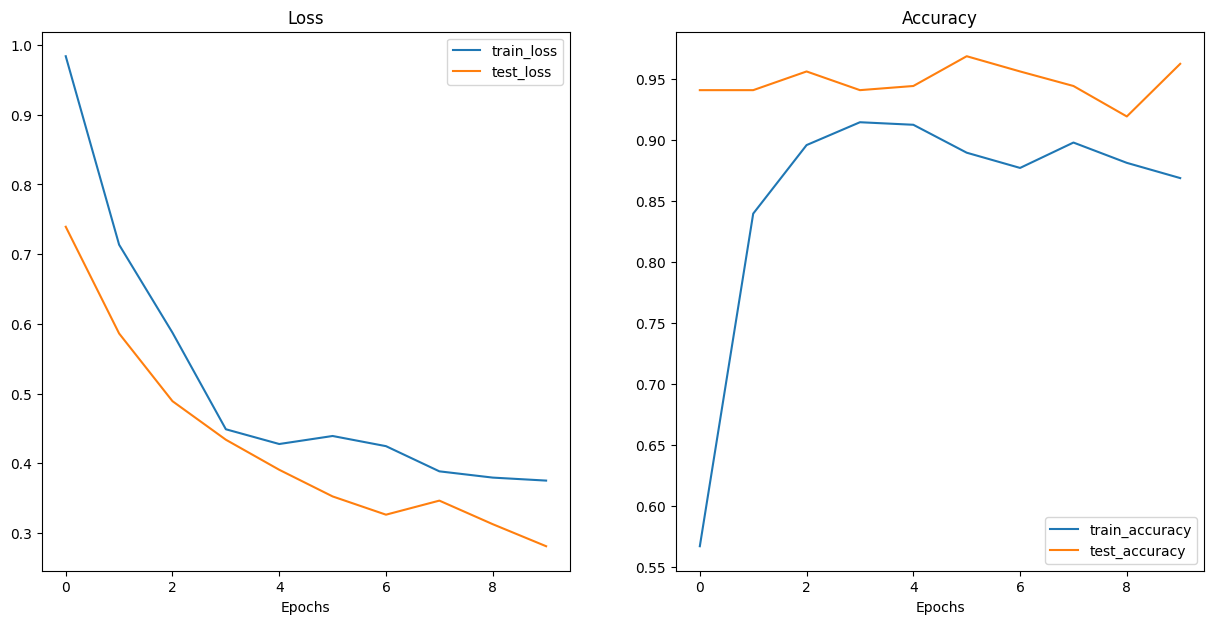

In [13]:
from helper_functions import plot_loss_curves
plot_loss_curves( effnetb2_results )

Those **Loss** and **Accuracy** curves look excellent.
Now, lets save our `effnetb2` model.

### 3.5 Saving EffNetB2 feature extractor

In [14]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(
    model      = effnetb2,
    target_dir = "models",
    model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspect the size of the EffNetB2 feature extractor model

Since we want our model to be deployed to an app/website, ideally we want the model size to be as small as possible without sacrificing accuracy.

In [15]:
from pathlib import Path

effnetb2_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"
# Get the model size
pretrained_effnetb2_size = Path(effnetb2_path).stat().st_size / (1024 * 1024) # divide by 1024^2 to get size in MB instead of bytes
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collect EffNetB2 stats

* Number of parameters: lower the better for good performance
* Test Loss: lower the better
* Test Accuracy: we want high accuracy

In [16]:
# Count the number of params in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params
effnetb2_results["test_loss"]

[0.7393137335777282,
 0.5862220644950866,
 0.48912095427513125,
 0.4338441789150238,
 0.39072914719581603,
 0.35251353979110717,
 0.3263223886489868,
 0.34649560153484343,
 0.3126934826374054,
 0.28108686208724976]

In [17]:
# Create a dict with EffNetB2 stats
effnetb2_stats = {
  "test_loss": effnetb2_results["test_loss"][-1], # '-1' index gives us the last value from the list
  "test_acc": effnetb2_results["test_acc"][-1],
  "number_of_parameters": effnetb2_total_params,
  "model_size(MB)": pretrained_effnetb2_size,
  }
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29.8638858795166}

## 4. Create ViT feature extractor

### 4.1 Create a function to create ViT feature extractor model

In [18]:
import torchvision
import torch
from typing import Tuple, Callable

def create_vit16_model(
  num_classes: int = 3,  # Default output classes = 3 (pizza, steak, and sushi)
  seed: int = None,
  classifier_dropout: float = 0.3,  # Dropout rate for the classifier
) -> Tuple[torch.nn.Module, Callable]:
  """Creates an ViT_B_16 feature extractor model.

  Args:
    num_classes (int, optional): Number of output classes. Defaults to 3.
    seed (int, optional): Random seed for reproducibility. Defaults to None.
    classifier_dropout (float, optional): Dropout rate for the classifier head. Defaults to 0.3.

  Returns:
    Tuple[nn.Module, Callable]: A tuple containing the ViT16 model and the associated transforms.

  Raises:
    ValueError: If `num_classes` is not a positive integer.

  Notes:
    - The expected input size for this model is 224x224 pixels.
    - Input images should be preprocessed using the provided `transforms`.
  """
  if num_classes <= 0:
    raise ValueError("`num_classes` must be a positive integer.")

  # 1, 2, 3 Create VitB16 pretrained weights, transforms, and model instance
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with (optional) random seed for reproducibility
  if seed:
    torch.manual_seed(seed)

  set_seeds()
  model.heads = nn.Sequential (
    nn.Linear(
      in_features  = 768,
      out_features = len(class_names),
    )
  )

  return model, transforms

In [19]:
vit16, vit16_transforms = create_vit16_model(
    num_classes = 3,
    seed        = 42,
)
vit16_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 162MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [20]:
# Check the layers using `summary()`
random_input_image = (1, 3, 224, 224)
summary(
    model        = vit16,
    input_size   = random_input_image,
    col_names    = ["input_size", "output_size", "num_params", "trainable"],
    col_width    = 20,
    row_settings = ["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.2 Creating DataLoaders for ViT_B_16 feature extractor


In [21]:
# Setup Dataloader
from going_modular.going_modular import data_setup

train_dl_vit16, test_dl_vit16, class_names = data_setup.create_dataloaders(
    train_dir  = train_dir,
    test_dir   = test_dir,
    transform  = vit16_transforms,
    batch_size = 32,
)
len(train_dl_vit16), len(test_dl_vit16), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.3. Train ViT16 feature extractor model

In [22]:
from going_modular.going_modular import engine

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Create optimizer and loss function
optimizer = torch.optim.Adam(
    params = vit16.parameters(),
    lr     = 1e-3,
)

# Training function (engine.py)
set_seeds()
vit16_results = engine.train(
    model            = vit16,
    train_dataloader = train_dl_vit16,
    test_dataloader  = test_dl_vit16,
    epochs           = 10,
    optimizer        = optimizer,
    loss_fn          = criterion,
    device           = device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.4 Inspect ViT16 loss and accuracy curves

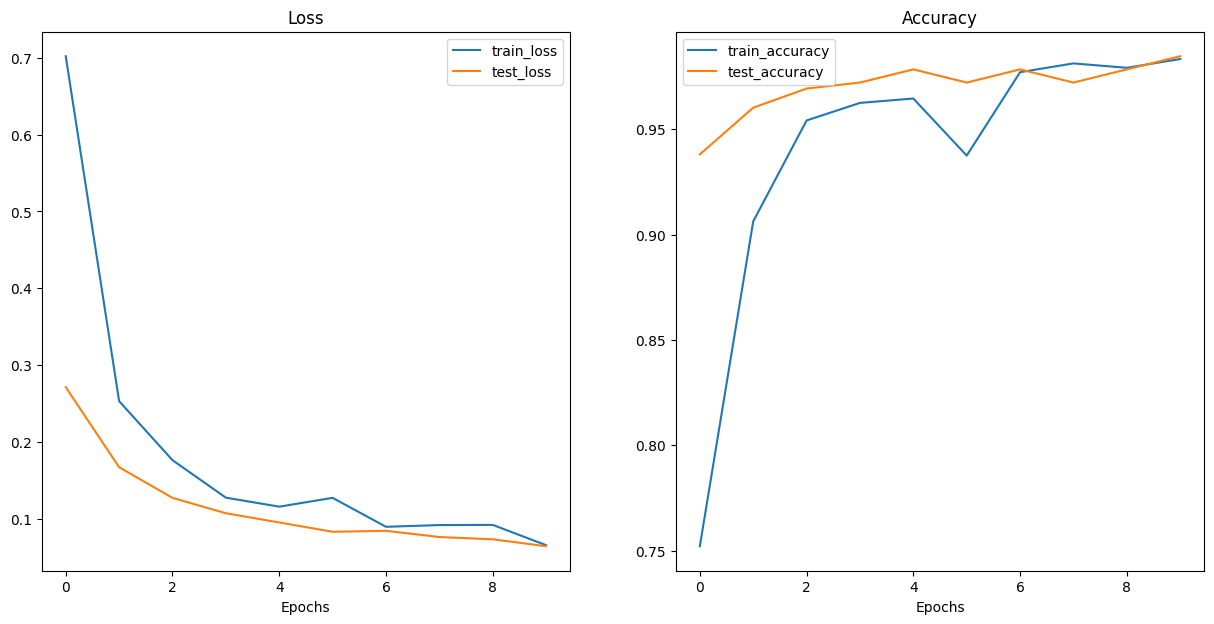

In [23]:
from helper_functions import plot_loss_curves

plot_loss_curves( vit16_results )

### 4.5 Saving ViT16 feature extractor


In [24]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(
    model      = vit16,
    target_dir = "models",
    model_name = "09_pretrained_vit16_feature_extractor_pizza_steak_sushi_20_percent.pth",
)

[INFO] Saving model to: models/09_pretrained_vit16_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.6 Inspect the size of the ViT16 feature extractor model
Since we want our model to be deployed to an app/website, ideally we want the model size to be as small as possible without sacrificing accuracy.

In [25]:

from pathlib import Path

vit16_path = "models/09_pretrained_vit16_feature_extractor_pizza_steak_sushi_20_percent.pth"
# Get the model size
pretrained_vit16_size = Path(vit16_path).stat().st_size / (1024 * 1024) # divide by 1024^2 to get size in MB instead of bytes
print(f"Pretrained ViT16 feature extractor model size: {round(pretrained_vit16_size, 2)} MB")

Pretrained ViT16 feature extractor model size: 327.37 MB


### 4.7 Collect  stats
* Number of parameters: lower the better for good performance
* Test Loss: lower the better
* Test Accuracy: we want high accuracy

In [26]:
# Count the number of params in ViT16
vit16_total_params = sum(torch.numel(param) for param in vit16.parameters())

# Create a dict with EffNetB2 stats
vit16_stats = {
  "test_loss": vit16_results["test_loss"][-1], # '-1' index gives us the last value from the list
  "test_acc": vit16_results["test_acc"][-1],
  "number_of_parameters": vit16_total_params,
  "model_size(MB)": pretrained_vit16_size,
  }
vit16_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327.37132835388184}

In [27]:
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29.8638858795166}

## 5. Making predictions with our trained models and timing them

Since we'd like to make predictions across all the images in the test set, let's first get a list of all of the test image paths so we can iterate over them.

In [28]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

Now we've got a list of our test image paths, let's get to work on our pred_and_store() function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by inferring the class from the path).
6. Start the prediction timer using Python's `timeit.default_timer()`.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as `NumPy` and `pandas` for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

In [29]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2
Time to test out our pred_and_store() function!

Let's start by using it to make predictions across the test dataset with our EffNetB2 model, paying attention to two details:

1. **Device** - We'll hard code the device parameter to use "cpu" because when we deploy our model, we won't always have access to a "cuda" (GPU) device.
  - Making the predictions on CPU will be a good indicator of speed of inference too because generally predictions on CPU devices are slower than GPU devices.
2. **Transforms** - We'll also be sure to set the `transform` parameter to `effnetb2_transforms` to make sure the images are opened and transformed in the same way our effnetb2 model has been trained on.

In [30]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

Thanks to our list of dictionaries data structure, we've got plenty of useful information we can further inspect.

To do so, let's turn our list of dictionaries into a pandas DataFrame.

In [31]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9558,pizza,0.3210,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7435,pizza,0.1208,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.5599,pizza,0.1252,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9211,pizza,0.1028,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8828,pizza,0.1354,True


In [32]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


And how about the average prediction time?



In [33]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1008 seconds


how does that average prediction time live up to our criteria of our model performing at real-time (~30FPS or 0.03 seconds per prediction)?

Let's add our `EffNetB2` average time per prediction to our `effnetb2_stats` dictionary.

In [34]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1008}

### 5.3 Making and timing predictions with ViT
We've made predictions with our EffNetB2 model, now let's do the same for our ViT model.



In [35]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit16,
                                     transform=vit16_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

And just like before, since our ViT model's predictions are in the form of a list of dictionaries, we can easily turn them into a pandas DataFrame for further inspection.

In [36]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9981,pizza,0.8682,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9980,pizza,0.3714,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9984,pizza,0.3608,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9987,pizza,0.3648,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9982,pizza,0.3685,True


How many predictions did our ViT model get correct?



In [37]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


Our ViT model did a little better than our EffNetB2 model in terms of correct predictions, only two samples wrong across the whole test dataset.

How about we calculate how long the ViT model took per prediction?

In [38]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4011 seconds


In [39]:
# Add average prediction time for ViT model on CPU
vit16_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit16_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327.37132835388184,
 'time_per_pred_cpu': 0.4011}

In [40]:
effnetb2_stats, vit16_stats

({'test_loss': 0.28108686208724976,
  'test_acc': 0.9625,
  'number_of_parameters': 7705221,
  'model_size(MB)': 29.8638858795166,
  'time_per_pred_cpu': 0.1008},
 {'test_loss': 0.06443451717495918,
  'test_acc': 0.984659090909091,
  'number_of_parameters': 85800963,
  'model_size(MB)': 327.37132835388184,
  'time_per_pred_cpu': 0.4011})

## 6. Comparing model results, prediction times, and size

In [41]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit16_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT_B_16"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1008,EffNetB2
1,0.064435,98.47,85800963,327.371328,0.4011,ViT_B_16


It seems our models are quite close in terms of overall test accuracy but how do they look across the other fields?

One way to find out would be to divide the ViT model statistics by the EffNetB2 model statistics to find out the different ratios between the models.

Let's create another DataFrame to do so.

In [42]:
df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863886,0.1008,EffNetB2
1,0.064435,98.47,85800963,327.371328,0.4011,ViT_B_16


In [43]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT_B_16"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962114,3.979167


It seems our ViT model outperforms the EffNetB2 model across the performance metrics (test loss, where lower is better and test accuracy, where higher is better) but at the expense of having:

* 11x+ the number of parameters.
* 11x+ the model size.
* 2.5x+ the prediction time per image

**Are these tradeoffs worth it?**

Perhaps if we had unlimited compute power but for our use case of deploying the FoodVision Mini model to a smaller device (e.g. a mobile phone), we'd likely start out with the EffNetB2 model for faster predictions at a slightly reduced performance but dramatically smaller size.

### 6.1 Visualizing the speed vs. performance tradeoff

How about we make this fact visual?

We can do so by creating a plot with matplotlib:

1. Create a scatter plot from the comparison `DataFrame` to compare `EffNetB2` and `ViT time_per_pred_cpu` and `test_acc` values.
2. Add titles and labels respective of the data and customize the fontsize for aesthetics.
3. Annotate the samples on the scatter plot from step 1 with their appropriate labels (the model names).
4. Create a legend based on the model sizes (`model_size (MB)`).

In [44]:
!mkdir images/


mkdir: cannot create directory ‘images/’: File exists


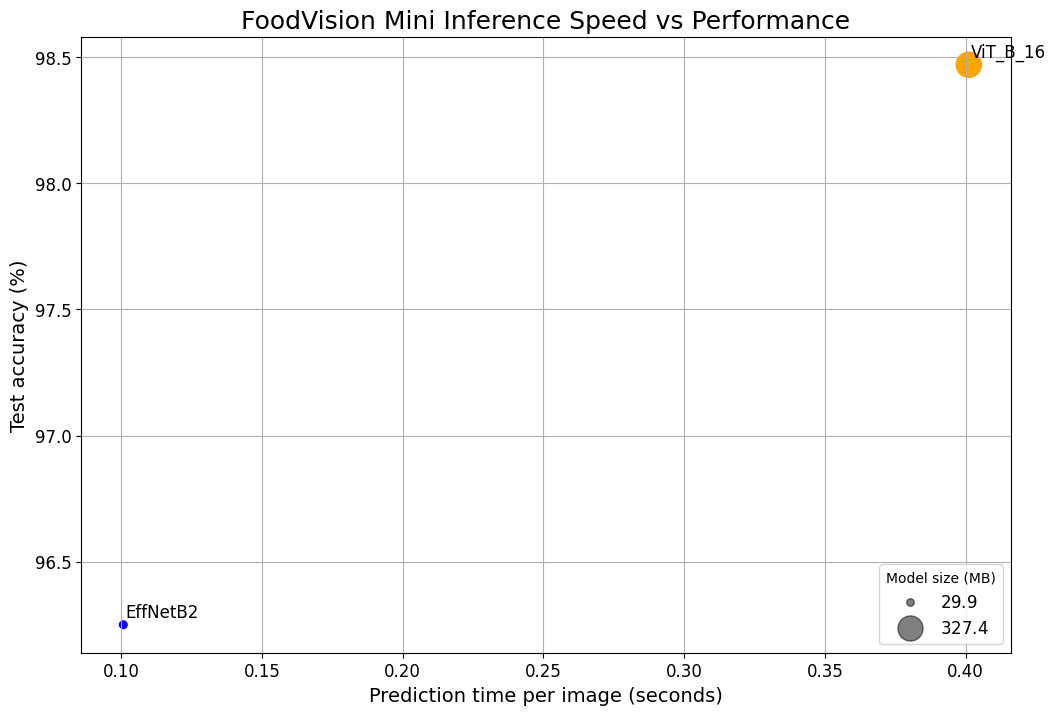

In [45]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size(MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images/

plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

The plot really visualizes the speed vs. performance tradeoff, in other words, when you have a larger, better performing deep model (like our ViT model), it generally takes longer to perform inference (higher latency).

There are exceptions to the rule and new research is being published all the time to help make larger models perform faster.

And it can be tempting to just deploy the best performing model but it's also good to take into consideration where the model is going to be performing.

In our case, the differences between our model's performance levels (on the test loss and test accuracy) aren't too extreme.

But since we'd like to put an emphasis on speed to begin with, we're going to stick with deploying EffNetB2 since it's faster and has a much smaller footprint.

## 7. Bringing FoodVision Mini to life by creating a Gradio demo


What's Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

https://gradio.app


In [46]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.9 MB/s eta 0:00:00
Gradio version: 5.9.1


### 7.1 Gradio overview

Gradio helps you create ML demos so that other people can try/use/test them in the real-world.

The overall premise of Gradio is to map `inputs` -> `function/model` -> `outputs`

In our case, for FoodVision Mini, our inputs are images of food, our ML model is EffNetB2 and our outputs are classes of food (pizza, steak or sushi).

> images of food -> EffNetB2 -> outputs

Gradio emulates this paradigm by creating an interface (`gradio.Interface()`) from inputs to outputs.

 `gradio.Interface(fn, inputs, outputs)`

Where, `fn` is a Python function to map the inputs to the outputs.

### 7.2 Creating a function to map our inputs and outputs
To create our FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

In [47]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a `predict()` function to go from:

> images of food -> ML model (EffNetB2) -> outputs (food class label, prediction_time)

In [48]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [49]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(image)

pred_dict, pred_time


[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg



({'pizza': 0.7433850169181824,
  'steak': 0.022059625014662743,
  'sushi': 0.23455537855625153},
 0.09746)

### 7.3 Creating a list of examples for Gradio listing

See how to initialise Gradio [here](https://www.gradio.app/docs/gradio/interface#initialization)

In [50]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg']]

### 7.4 Build a Gradio Interface

Time to put everything together and bring our FoodVision Mini demo to life!


Let's create a Gradio interface to replicate the workflow:
>input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken



In [51]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(
    fn          = predict, # mapping function from input to output
    inputs      = gr.Image(type="pil"), # what are the inputs?
    outputs     = [
                   gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                   gr.Number(label="Prediction time (s)")
                  ], # our fn has two outputs, therefore we have two outputs
    examples    = example_list,
    title       = title,
    description = description,
    article     = article)

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b71ff3068c90110551.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b71ff3068c90110551.gradio.live


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app



### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

### 8.2 Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


### 8.3 Create a demos folder to store our FoodVision app files



In [52]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# If the path already exists, remove it and recreate it
# will help with Colab rerun, start from fresh everytime we run this cell
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(
      parents  = True,
      exist_ok = True,
  )
else:
  foodvision_mini_demo_path.mkdir(
      parents  = True,
      exist_ok = True,
  )

  !ls demos

foodvision_mini


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo


In [53]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Now to verify our examples are present, let's list the contents of our `demos/foodvision_mini/examples/` directory with `os.listdir()` and then format the filepaths into a list of lists (so it's compatible with Gradio's `gradio.Interface()` example parameter).



In [54]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [55]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (`model.py`)

Let's create a script called `model.py` which contains our `create_effnetb2_model()` function.

We'll use the `%%writefile path/to/file` magic command to turn a cell of code into a file.

In [56]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

Our `app.py` script will put together all of the pieces of the puzzle to create our Gradio demo and will have four main parts:

1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_effnetb2_model()` function from `model.py` as well as setup the different class names for our FoodVision Mini app.
2. **Model and transforms preparation** - Here we'll create an `EffNetB2` model instance along with the transforms to go with it and then we'll load in the saved model weights/state_dict. When we load the model we'll also set `map_location=torch.device("cpu")` in `torch.load()` so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).
3. **Predict function** - Gradio's `gradio.Interface()` takes a fn parameter to map inputs to outputs, our `predict()` function, it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
  > Note: We'll have to create the example list on the fly via the examples parameter. We can do so by creating a list of the files inside the examples/ directory with: `[["examples/" + example]` for example in `os.listdir("examples")]`.
4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called demo to put together our inputs, `predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our FoodVision Mini demo!

In [57]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

The good news is, there's only three!

* torch==1.12.0
* torchvision==0.13.0
* gradio==3.1.4

In [58]:
%%writefile demos/foodvision_mini/requirements.txt
torch>=1.12.0
torchvision>=0.13.0
gradio>=3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

1. Uploading via the Hugging Face Web interface (easiest).
2. Uploading via the command line or terminal.


### 9.1 Downloading our FoodVision Mini app files

In [59]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


These are all files that we've created!

To begin uploading our files to Hugging Face, let's now download them from Google Colab (or wherever you're running this notebook).

To do so, we'll first compress the files into a single zip folder via the command:

In [60]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")


  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Run the app locally

DONE!!

### 9.3 Uploading to Hugging Face

DONE !!
See here - https://huggingface.co/spaces/anupj/foodvision_mini

In [72]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big

Since FoodVision Mini is trained on pizza, steak and sushi images from the Food101 dataset (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101!
Let's recreate a Gradio demo similar to FoodVision Mini (three classes) but for FoodVision Big (101 classes).
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-model-deployment-foodvision-mini-to-foodvision-big.png)

### 10.1 Creating a model and transforms for FoodVision Big

When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

When creating FoodVision Mini we saw that the `EffNetB2` model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

In [75]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model( num_classes = 101 )

In [73]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(
    effnetb2_food101,
    input_size   = (1, 3, 224, 224),
    col_names    = ["input_size", "output_size", "num_params", "trainable"],
    col_width    = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Now since we're going to be dealing with a fair bit more data than usual, how about we add a little data augmentation to our transforms (`effnetb2_transforms`) to augment the training data.

> **Note**: Data augmentation is a technique used to alter the appearance of an input training sample (e.g. rotating an image or slightly skewing it) to artificially increase the diversity of a training dataset to hopefully prevent overfitting.

Let's compose a `torchvision.transforms` pipeline to use `torchvision.transforms.TrivialAugmentWide()`, as well as the `effnetb2_transforms` to transform our training images.

In [76]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

Now, let's compare `food101_train_transforms` (for training data) and `effnetb2_transforms` (for the testing/inference data)

In [65]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big

To get the whole Food101 dataset, we can use `torchvision.datasets.Food101()`.

We'll first setup a path to directory `data/` to store the images.

Then we'll download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively.

In [77]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 image  x 101 food classes)
train_data    = datasets.Food101(
    root      = data_dir, # dir for downloaded data
    split     = "train", # dataset split to get
    transform = food101_train_transforms, # perform data augmentatio on training data
    download  = True,
)

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(
    root      = data_dir,
    split     = "test",
    transform = effnetb2_transforms, # perform normal EffnetB2 transform
    download  = True,
)

In [78]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

 ### 10.3 Creating a subset of the Food101 dataset for faster experimenting

 We don't need to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original [Food101 paper's](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) best results with only 20% of the data.

| Notebook(s)           | Project name                | Dataset                | Number of classes                 | Training images | Testing images |
|-----------------------|-----------------------------|------------------------|-----------------------------------|----------------|---------------|
| 04, 05, 06, 07, 08    | FoodVision Mini (10% data)  | Food101 custom split  | 3 (pizza, steak, sushi)          | 225            | 75            |
| 07, 08, 09            | FoodVision Mini (20% data)  | Food101 custom split  | 3 (pizza, steak, sushi)          | 450            | 150           |
| 09 (this one)         | FoodVision Big (20% data)   | Food101 custom split  | 101 (all Food101 classes)        | 15150          | 5050          |
| Extension             | FoodVision Big              | Food101 all data      | 101                               | 75750          | 25250         |

Just like our model size slowly increased overtime, so has the size of the dataset we've been using for experiments.

In [79]:
def split_dataset(
    dataset:torchvision.datasets,
    split_size:float = 0.2,
    seed:int         = 42
  ):
  """Randomly splits a given dataset into two proportions based on split_size and seed.

  Args:
    dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
    split_size (float, optional): How much of the dataset should be split?
        E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
    seed (int, optional): Seed for random generator. Defaults to 42.

  Returns:
    tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
        random_split_2 is of size (1-split_size)*len(dataset).
  """
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # desired length
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(
    dataset,
    lengths   = [length_1, length_2],
    generator = torch.manual_seed(seed) # set the random seed for reproducible splits
  )
  return random_split_1, random_split_2

Now let's test it out by creating a 20% training and testing dataset split of Food101.



In [80]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoaders`

Now let's turn our Food101 20% dataset splits into `DataLoader`'s using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `4` if the CPU count is available or `2` if it's not.



In [81]:
import os
import torch

BATCH_SIZE  = 32
NUM_WORKERS = 2 if os.cpu_count() <=4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training Dataloader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    train_data_food101_20_percent,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS,
)

# Create Food101 20 percent testing Dataloader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    test_data_food101_20_percent,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS,
)

### 10.5 Training FoodVision Big model

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with torchvision's state-of-the-art training recipe.

**What's label smoothing?**

Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

Finally, to keep things quick, we'll train our model for five epochs.

In [82]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(
  params=effnetb2_food101.parameters(),
  lr=1e-3
)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss( label_smoothing = 0.1 ) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(
  model            = effnetb2_food101,
  train_dataloader = train_dataloader_food101_20_percent,
  test_dataloader  = test_dataloader_food101_20_percent,
  optimizer        = optimizer,
  loss_fn          = loss_fn,
  epochs           = 5,
  device           = device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6441 | train_acc: 0.2770 | test_loss: 2.7802 | test_acc: 0.4907
Epoch: 2 | train_loss: 2.8635 | train_acc: 0.4421 | test_loss: 2.4720 | test_acc: 0.5353
Epoch: 3 | train_loss: 2.6561 | train_acc: 0.4855 | test_loss: 2.3623 | test_acc: 0.5551
Epoch: 4 | train_loss: 2.5452 | train_acc: 0.5113 | test_loss: 2.3028 | test_acc: 0.5741
Epoch: 5 | train_loss: 2.4974 | train_acc: 0.5256 | test_loss: 2.2796 | test_acc: 0.5800


### 10.6 Inspecting loss curves of FoodVision Big model
Let's make our FoodVision Big loss curves visual.

We can do so with the `plot_loss_curves()` function from `helper_functions.py`.

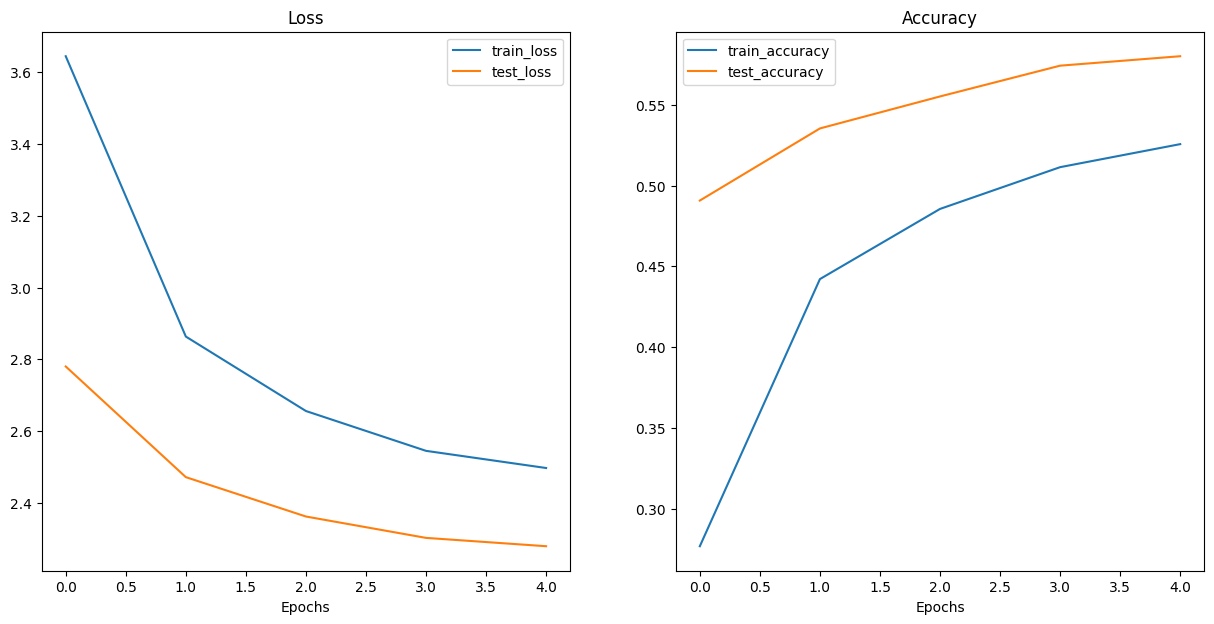

In [83]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [84]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(
    model      = effnetb2_food101,
    target_dir = "models",
    model_name = effnetb2_food101_model_path
)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


### 10.8 Checking FoodVision Big model size

In [86]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


Hmm, it looks like the model size stayed largely the same (30 MB for FoodVision Big and 29 MB for FoodVision Mini) despite the large increase in the number of classes.

This is because all the extra parameters for FoodVision Big are only in the last layer (the classifier head).

All of the base layers are the same between FoodVision Big and FoodVision Mini.

Going back up and comparing the model summaries will give more details.

## 11. Turning our FoodVision Big model into a deployable app

We'll deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

When we're finished we'll have the following file structure:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```




In [87]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory



In [88]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-01-02 16:08:33--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2025-01-02 16:08:33 (61.4 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (class_names.txt)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our `app.py file`, let's save them to a `.txt` file and read them in when necessary instead.

```
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
...
....
````




In [89]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [92]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

Just like the FoodVision Mini demo, let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.



In [93]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Overwriting demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script

In [94]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)


In [97]:
%%writefile demos/foodvision_big/requirements.txt
torch>=1.12.0
torchvision>=0.13.0
gradio>=3.1.4

Overwriting demos/foodvision_big/requirements.txt


## 11.6 Downloading our FoodVision Big app files

In [98]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big app to HuggingFace Spaces

DONE !!
See here: https://huggingface.co/spaces/anupj/foodvision_big